In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model('../models/wine_quality_classifier.h5')
model.trainable = False
X_test, Y_test = np.load("../dataset/wine_quality_X_test.npy"), np.load("../dataset/wine_quality_Y_test.npy")

def prediction_to_word(pred):
    if np.argmax(pred) == 0:
        return 'Bad'
    elif np.argmax(pred) == 1:
        return 'Average'
    else:
        return 'Good'

In [3]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input, label):
  input_tensor = tf.convert_to_tensor(input.reshape(1, 12), dtype=tf.float32)
  label_tensor = tf.convert_to_tensor(label.reshape(1, 3), dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    loss = loss_object(label_tensor, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_tensor)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def create_adversarial_example(input, label, eps):
  perturbations = create_adversarial_pattern(input, label)
  adversarial_example = input + eps * perturbations
  return adversarial_example

In [4]:
budget = 0.1
index = 100

prediction = model(X_test[index].reshape(1, 12))
attacked_prediction = model(create_adversarial_example(X_test[index], Y_test[index], budget))
print(f"Actual label:             {prediction_to_word(Y_test[index])}")
print(f"Prediction before attack: {prediction_to_word(prediction.numpy()[0])} ({100*np.max(prediction.numpy()):.2f}%)")
print(f"Prediction after attack:  {prediction_to_word(attacked_prediction.numpy()[0])} ({100*np.max(attacked_prediction.numpy()):.2f}%)")

Actual label:             Bad
Prediction before attack: Bad (62.31%)
Prediction after attack:  Average (47.77%)


Saved attacked dataset for budget 0.05
Saved attacked dataset for budget 0.10
Saved attacked dataset for budget 0.20
Saved attacked dataset for budget 0.30
Saved attacked dataset for budget 0.50
Saved attacked dataset for budget 0.80
Saved attacked dataset for budget 1.00


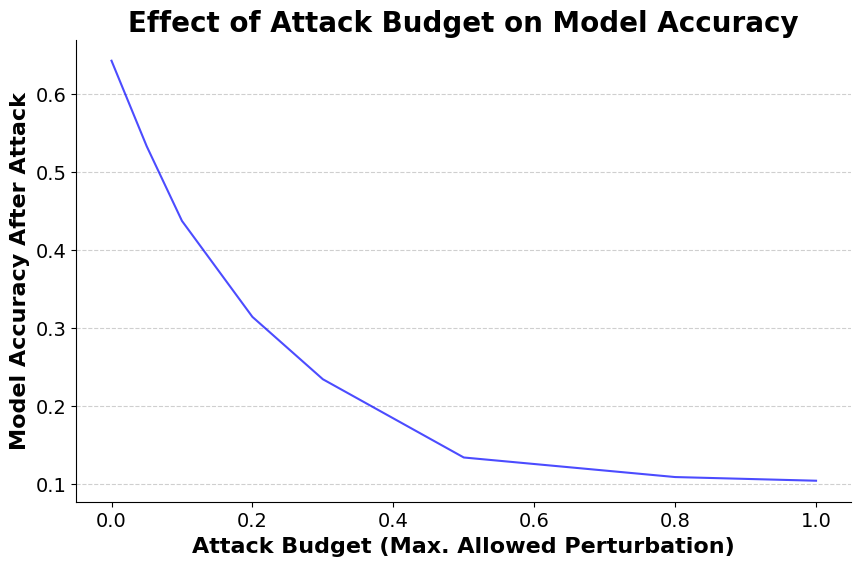

In [6]:
def evaluate_attack(budget):
    correct = 0
    for i in range(len(X_test)):
        attacked_prediction = model(
            create_adversarial_example(X_test[i], Y_test[i], budget))
        if np.argmax(attacked_prediction) == np.argmax(Y_test[i]):
            correct += 1
    return correct / len(X_test)


budgets = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
for budget in budgets[1:]:
    attacked_dataset = []
    for i in range(len(X_test)):
        attacked_dataset.append(
            create_adversarial_example(X_test[i], Y_test[i], budget))
    np.save(
        f"../dataset/wine_quality_X_test_attacked_{budget:.2f}", np.array(attacked_dataset))
    print(f"Saved attacked dataset for budget {budget:.2f}")


accuracies = [evaluate_attack(budget) for budget in budgets]

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(budgets, accuracies, color="blue", label='Accuracy', alpha=0.7)

ax.set_title("Effect of Attack Budget on Model Accuracy",
             fontsize=20, fontweight='bold')
ax.set_xlabel("Attack Budget (Max. Allowed Perturbation)",
              fontsize=16, fontweight='bold')
ax.set_ylabel("Model Accuracy After Attack", fontsize=16, fontweight='bold')

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()